In [ ]:
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, IntSlider, ToggleButtons
from tensorflow.keras.models import load_model

# Custom objects required for loading the U-Net segmentation models
import sys
sys.path.append('..')
from segmentation_losses import (
    dice_coefficient,
    dice_loss,
    log_cosh_dice_loss,
    iou
)

In [ ]:
# Load the best model for inference
model = load_model(
    "Models/unet_3d_segmentation_model_conv3dtranspose_batchnormalization128_dice.h5",
    custom_objects={
        "log_cosh_dice_loss": log_cosh_dice_loss,
        "dice_coefficient": dice_coefficient,
        "iou": iou
    }
)

In [ ]:
# Standadise the MRI image before producing inferences
def standardize(mri):
    standardized_mri = np.zeros(mri.shape)

    # Iterate over channels
    for c in range(mri.shape[3]):
        # Iterate over the `z` depth dimension
        for z in range(mri.shape[2]):
            # Get a slice of the mri at channel c and z-th dimension
            mri_slice = mri[:, :, z, c]

            # Subtract the mean from mri_slice
            centered = mri_slice - np.mean(mri_slice)

            # Divide by the standard deviation (only if it is different from zero)
            if np.std(centered) != 0:
                centered_scaled = centered / np.std(centered)

                # Update the slice of standardized mri with the centered and scaled mri
                standardized_mri[:, :, z, c] = centered_scaled

    return standardized_mri

In [ ]:
# Generate the prediction segemnetation for a given image
def pred_mask(mri,mask,model):
    mri_standardized = standardize(mri)
    mri_standardized = np.expand_dims(mri_standardized, axis=0)
    prediction = model.predict(mri_standardized)
    prediction = np.squeeze(prediction, axis=0)  # Remove 'batch_size' dimension
    prediction = np.argmax(prediction, axis=3)
    print('Shape of the Predicted Mask',prediction.shape)
    print('No of classes in the Predicted Mask',np.unique(prediction))

    return prediction


In [ ]:
# Plot the slice by by predictions
from matplotlib import colors

def plot_prediction(mri,mask,prediction,slice_no,channel):
    slice_num = slice_no  # example slice number (choose between 0 and 154)
    channel = channel     # example channel (0: FLAIR, 1: T1, 2: T1-Gd, 3: T2)
    #cmap = colors.ListedColormap(['black', 'red','green','yellow','blue'])

    # Extract the corresponding slice and channel from the transformed image and mask
    slice_image = mri[:, :, slice_num, channel]
    slice_mask = mask[:, :, slice_num]

    pred_slice = prediction[:, :, slice_num]

    # Original image and mask
    fig, axes = plt.subplots(1, 3, figsize=(10, 10))
    axes[0].imshow(slice_image,cmap='gray')
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    axes[1].imshow(slice_mask)
    axes[1].set_title('Original Mask')
    axes[1].axis('off')

    # Predicted mask
    axes[2].imshow(pred_slice)
    axes[2].set_title('Predicted Mask')
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
def plot_results_byclass(mri, mask, prediction,mod_no, slice_num=None):
    colors = ['#440154', '#3b528b', '#21918c', '#fde725', '#d62728']  # Black, Blue, Orange, Green, Red
    cmap = [LinearSegmentedColormap.from_list(f'custom_{i}', ['#440154', color], N=256) for i, color in enumerate(colors)]

    if slice_num is None:
        slice_num = mri.shape[2] // 2  # Middle slice by default

    # Determine the number of unique classes in the prediction
    num_classes = len(np.unique(prediction))

    # Create a figure with a row for each class plus two additional rows
    fig, axes = plt.subplots(1, 5, figsize=(15, 5))
    fig.suptitle(f"MRI Segmentation Results - Slice {slice_num}", fontsize=16)

    # Plot true image slice (using the first channel of MRI)
    axes[0].imshow(mri[:, :, slice_num, mod_no], cmap='gray')
    axes[0].set_title("MRI Image Slice")
    axes[0].axis('off')

    # Plot ground truth mask
    axes[1].imshow(mask[:, :, slice_num], cmap='viridis')
    axes[1].set_title("Ground Truth Mask")
    axes[1].axis('off')

    # Plot prediction mask for class 1 edema
    class_mask = (prediction[:, :, slice_num] == 1).astype(int)
    axes[2].imshow(class_mask, cmap=cmap[1])
    axes[2].set_title("Edema")
    axes[2].axis('off')

    # Plot prediction mask for class 2 non-enhancing
    class_mask = (prediction[:, :, slice_num] == 2).astype(int)
    axes[3].imshow(class_mask, cmap=cmap[2])
    axes[3].set_title("Non-enhancing")
    axes[3].axis('off')

    # Plot prediction mask for class 2 non-enhancing
    class_mask = (prediction[:, :, slice_num] == 3).astype(int)
    axes[4].imshow(class_mask, cmap=cmap[3])
    axes[4].set_title("Enhancing")
    axes[4].axis('off')

    plt.tight_layout()
    plt.show()


Prediction -1

In [ ]:
mri = nib.load("/home/manuri/data/3D_multi/output/val/images/BRATS_207.nii.gz").get_fdata().astype(np.float32)

In [ ]:
mask = nib.load("/home/manuri/data/3D_multi/output/val/masks/BRATS_207.nii.gz").get_fdata().astype(np.uint8)

In [ ]:
print(mri.shape)
print(mask.shape)

(128, 128, 160, 4)
(128, 128, 160)


In [ ]:
prediction = pred_mask(mri,mask,model)

Shape of the Predicted Mask (128, 128, 160)
No of classes in the Predicted Mask [0 1 2 3]


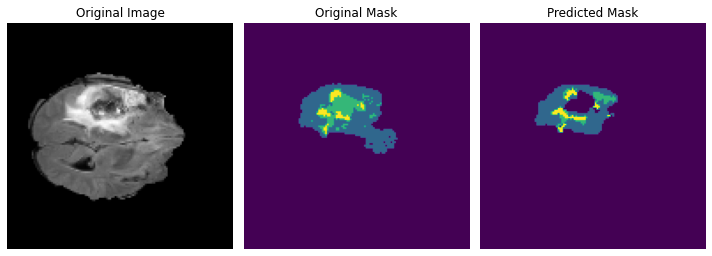

In [ ]:
plot_prediction(mri,mask,prediction,slice_no=65,channel=0)

In [ ]:
plot_results_byclass(mri,mask,prediction,0,65)

Prediction - 2

In [ ]:
mask = nib.load("/home/manuri/data/3D_multi/output/val/masks/BRATS_469.nii.gz").get_fdata().astype(np.uint8)

In [ ]:
mri = nib.load("/home/manuri/data/3D_multi/output/val/images/BRATS_469.nii.gz").get_fdata().astype(np.float32)

In [ ]:
prediction = pred_mask(mri,mask,model)

Shape of the Predicted Mask (128, 128, 160)
No of classes in the Predicted Mask [0 1 2 3]


In [ ]:
middle_slice = mri.shape[2] // 2
print(middle_slice)

80


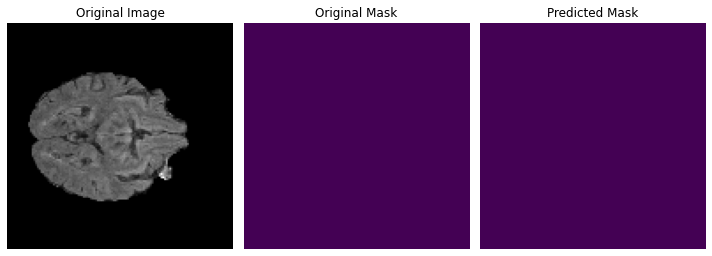

In [ ]:
plot_prediction(mri,mask,prediction,60,0)

Prediction-3

In [ ]:
mask = nib.load("/home/manuri/data/3D_multi/output/val/masks/BRATS_154.nii.gz").get_fdata().astype(np.uint8)

In [ ]:
mri = nib.load("/home/manuri/data/3D_multi/output/val/images/BRATS_154.nii.gz").get_fdata().astype(np.float32)

In [ ]:
prediction = pred_mask(mri,mask,model)

Shape of the Predicted Mask (128, 128, 160)
No of classes in the Predicted Mask [0 1 2 3]


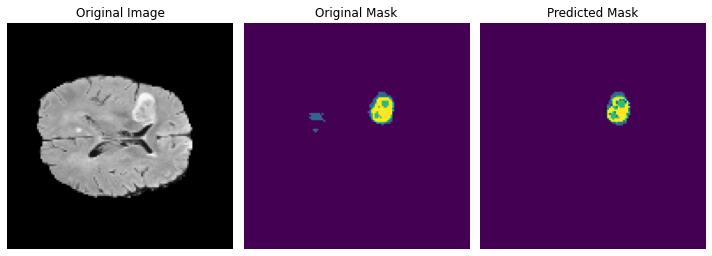

In [ ]:
plot_prediction(mri,mask,prediction,80,0)

In [ ]:
plot_results_byclass(mri,mask,prediction,0,80)

Prediction-4

In [ ]:
mask = nib.load("/home/manuri/data/3D_multi/output/val/masks/BRATS_037.nii.gz").get_fdata().astype(np.uint8)

In [ ]:
mri = nib.load("/home/manuri/data/3D_multi/output/val/images/BRATS_037.nii.gz").get_fdata().astype(np.float32)

In [ ]:
prediction = pred_mask(mri,mask,model)

Shape of the Predicted Mask (128, 128, 160)
No of classes in the Predicted Mask [0 1 2 3]


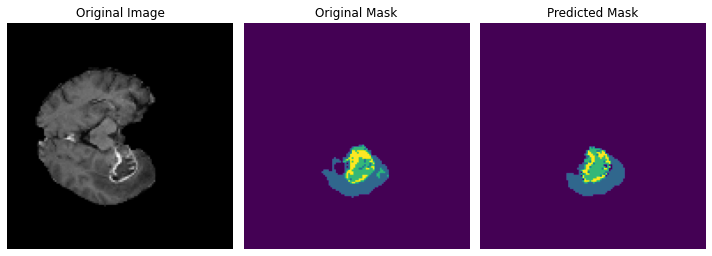

In [ ]:
plot_prediction(mri,mask,prediction,50,2)